<a href="https://colab.research.google.com/github/ssoyyoungg/practice/blob/main/Acc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ✅ pretrained ResNet에 맞는 Normalize (최소 필수)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ CIFAR10용 ResNet18 패치
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

device: cuda


100%|██████████| 170M/170M [05:34<00:00, 510kB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


In [2]:
for epoch in range(1,6):
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | /Train Loss : {train_loss:.4f} | Test Acc : {test_acc*100:.2f}%")

Epoch 1 | /Train Loss : 0.7894 | Test Acc : 84.44%
Epoch 2 | /Train Loss : 0.4015 | Test Acc : 88.00%
Epoch 3 | /Train Loss : 0.2927 | Test Acc : 90.01%
Epoch 4 | /Train Loss : 0.2362 | Test Acc : 90.50%
Epoch 5 | /Train Loss : 0.1889 | Test Acc : 91.03%


In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

print("Confusion matrix shape:", cm.shape)


Confusion matrix shape: (10, 10)


In [4]:
print("model.fc :", model.fc)

model.fc : Linear(in_features=512, out_features=10, bias=True)


클래스별 정확도 계산

In [7]:
row_sum = cm.sum(axis=1)
class_acc = np.diag(cm) / row_sum

for i, a in enumerate(class_acc):
    print(f"{classes[i]:>5} acc: {a*100:.2f}%  (correct={cm[i,i]}, total={row_sum[i]})")


airplane acc: 95.20%  (correct=952, total=1000)
automobile acc: 94.90%  (correct=949, total=1000)
 bird acc: 91.80%  (correct=918, total=1000)
  cat acc: 85.10%  (correct=851, total=1000)
 deer acc: 91.90%  (correct=919, total=1000)
  dog acc: 78.00%  (correct=780, total=1000)
 frog acc: 89.30%  (correct=893, total=1000)
horse acc: 94.20%  (correct=942, total=1000)
 ship acc: 95.30%  (correct=953, total=1000)
truck acc: 94.60%  (correct=946, total=1000)


오분류 TOP 자동 추출

In [8]:
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)

pairs = []
for i in range(cm_off.shape[0]):
    for j in range(cm_off.shape[1]):
        if cm_off[i, j] > 0:
            pairs.append((cm_off[i, j], i, j))

pairs.sort(reverse=True)

print("Top-10 confusion pairs (True -> Pred):")
for k, (cnt, i, j) in enumerate(pairs[:10], 1):
    print(f"{k:02d}. {classes[i]} -> {classes[j]} : {cnt}")

Top-10 confusion pairs (True -> Pred):
01. dog -> cat : 124
02. frog -> bird : 41
03. cat -> dog : 38
04. dog -> bird : 37
05. cat -> bird : 35
06. truck -> automobile : 29
07. frog -> cat : 29
08. automobile -> truck : 27
09. bird -> airplane : 26
10. ship -> airplane : 25


가장 많이 헷갈린 쌍 샘플 이미지 뽑기

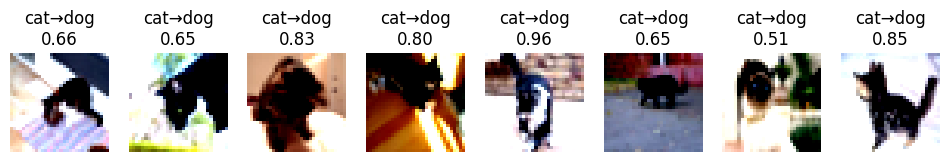

In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show_confused_samples(model, loader, true_cls, pred_cls, classes, device, max_show=8):
    model.eval()
    imgs = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            p = logits.argmax(1)

            mask = (y == true_cls) & (p == pred_cls)
            if mask.any():
                sel_x = x[mask].cpu()
                sel_logits = logits[mask].cpu()
                probs = F.softmax(sel_logits, dim=1)[:, pred_cls]
                for i in range(sel_x.size(0)):
                    imgs.append((sel_x[i], probs[i].item()))
                    if len(imgs) >= max_show:
                        break
            if len(imgs) >= max_show:
                break

    if len(imgs) == 0:
        print("해당 오분류 샘플을 찾을수 없습니다.")
        return

    plt.figure(figsize=(12, 3))
    for i, (img, conf) in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        # CIFAR는 (3,32,32)라서 HWC로 바꾸기
        img = img.permute(1,2,0)
        # Normalize(0.5,0.5,0.5) 되돌리기
        img = img * 0.5 + 0.5


        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{classes[true_cls]}→{classes[pred_cls]}\n{conf:.2f}")
    plt.show()

# 예시: cat(3) -> dog(5)
show_confused_samples(model, test_loader, true_cls=3, pred_cls=5, classes=classes, device=device, max_show=8)

학습 곡선 시각화

epoch 20으로 올림

In [33]:
train_losses = []
test_accs = []

for epoch in range(1, 21):
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


Epoch 1 | Train Loss: 0.0529 | Test Acc: 93.04%
Epoch 2 | Train Loss: 0.0494 | Test Acc: 92.55%
Epoch 3 | Train Loss: 0.0483 | Test Acc: 92.92%
Epoch 4 | Train Loss: 0.0478 | Test Acc: 93.60%
Epoch 5 | Train Loss: 0.0460 | Test Acc: 93.15%
Epoch 6 | Train Loss: 0.0432 | Test Acc: 93.30%
Epoch 7 | Train Loss: 0.0427 | Test Acc: 93.09%
Epoch 8 | Train Loss: 0.0426 | Test Acc: 93.24%
Epoch 9 | Train Loss: 0.0409 | Test Acc: 93.17%
Epoch 10 | Train Loss: 0.0372 | Test Acc: 93.19%
Epoch 11 | Train Loss: 0.0401 | Test Acc: 93.28%
Epoch 12 | Train Loss: 0.0424 | Test Acc: 93.09%
Epoch 13 | Train Loss: 0.0352 | Test Acc: 93.81%
Epoch 14 | Train Loss: 0.0416 | Test Acc: 93.37%
Epoch 15 | Train Loss: 0.0331 | Test Acc: 93.44%
Epoch 16 | Train Loss: 0.0326 | Test Acc: 93.22%
Epoch 17 | Train Loss: 0.0353 | Test Acc: 93.40%
Epoch 18 | Train Loss: 0.0373 | Test Acc: 93.32%
Epoch 19 | Train Loss: 0.0355 | Test Acc: 93.33%
Epoch 20 | Train Loss: 0.0298 | Test Acc: 93.51%


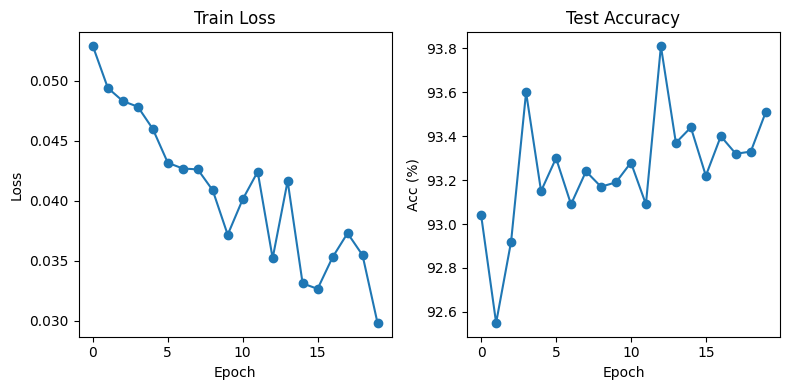

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot([a*100 for a in test_accs], marker='o')  # %로 보기 좋게
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc (%)")

plt.tight_layout()
plt.show()